In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import collections
import glob
from binarization import binary_threshold
from birdeyeperspective import birdeyeview
from cameracalibration import camera_calibration,undistort
from globals import xm_per_pix, time_window 



(720, 1280)


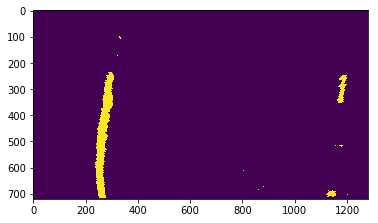

In [42]:
#take histogram of the bottom half of the image
ret, mtx, dist, rvecs, tvecs = camera_calibration()
img = cv2.imread('test_images/test1.jpg')
img_undis = undistort(img,mtx,dist,verbose=False)
img_bin = binary_threshold(img_undis,verbose=False)

binary_wrapped,M,Minv = birdeyeview(img_bin,verbose=False)
plt.imshow(binary_wrapped)
print(binary_wrapped.shape)






Text(0.5,1,'Lane Detected')

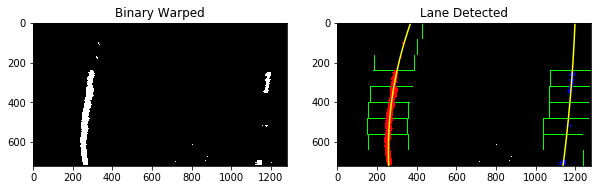

In [43]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_wrapped[binary_wrapped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_wrapped, binary_wrapped, binary_wrapped))*255

# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(binary_wrapped.shape[0]/nwindows)

# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_wrapped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])


# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 100

# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Steping through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_wrapped.shape[0] - (window+1)*window_height
    win_y_high = binary_wrapped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Drawing the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identifing the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Appending these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenating the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extracting left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization
ploty = np.linspace(0, binary_wrapped.shape[0]-1, binary_wrapped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(binary_wrapped, cmap='gray')
plt.title('Binary Warped')

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Detected')

In [44]:
ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
y_eval = 700
midx = 650

y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
print("Radius of Curvature: %f" % curvature)

Radius of Curvature: 567.311317


(720, 1280, 3)
(720, 1280, 3)


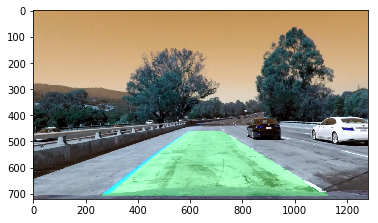

In [51]:
ploty = np.linspace(0, binary_wrapped.shape[0]-1, binary_wrapped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

warp_zero = np.zeros_like(binary_wrapped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (img_undis.shape[1], img_undis.shape[0]))
final = cv2.addWeighted(img_undis, 1, newwarp, 0.3, 0)

plt.imshow(final)
print(newwarp.shape)
print(img_undis.shape)

In [ ]:
from moviepy.editor import VideoFileClip
white_output = 'result_straight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import collections
import glob
from binarization import binary_threshold
from birdeyeperspective import birdeyeview
from cameracalibration import camera_calibration,undistort
from globals import xm_per_pix, time_window 


# plt.imshow(binary_wrapped)
# print(binary_wrapped.shape)
def fit_line(binary_wrapped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_wrapped[binary_wrapped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_wrapped, binary_wrapped, binary_wrapped))*255

    # Finding peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Number of sliding windows
    nwindows = 9

    # Height of windows
    window_height = np.int(binary_wrapped.shape[0]/nwindows)

    # Identifing the x and y positions of all nonzero pixels in the image
    nonzero = binary_wrapped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])


    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Margin in which to search
    margin = 100

    # Minimum number of pixels found to recenter window
    minpix = 50

    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Steping through windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_wrapped.shape[0] - (window+1)*window_height
        win_y_high = binary_wrapped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Drawing the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identifing the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Appending these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # Recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenating the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extracting left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ## Visualization
    ploty = np.linspace(0, binary_wrapped.shape[0]-1, binary_wrapped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    plt.figure(figsize=(10,40))
    plt.subplot(1,2,1)
    plt.imshow(binary_wrapped, cmap='gray')
    plt.title('Binary Warped')

    plt.subplot(1,2,2)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.title('Lane Detected')

    ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
    y_eval = 700
    midx = 650

    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
    print("Radius of Curvature: %f" % curvature)
    ploty = np.linspace(0, binary_wrapped.shape[0]-1, binary_wrapped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(binary_wrapped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_undis.shape[1], img_undis.shape[0]))
    final = cv2.addWeighted(img_undis, 1, newwarp, 0.3, 0)

    return final
    

Radius of Curvature: 567.311317


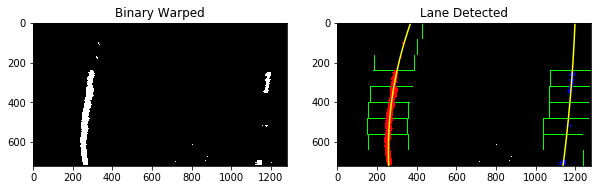

In [59]:
#take histogram of the bottom half of the image
ret, mtx, dist, rvecs, tvecs = camera_calibration()
img = cv2.imread('test_images/test1.jpg')
img_undis = undistort(img,mtx,dist,verbose=False)
img_bin = binary_threshold(img_undis,verbose=False)

binary_wrapped,M,Minv = birdeyeview(img_bin,verbose=False)
final =fit_line(binary_wrapped)

In [60]:
def fit_continuous(left_fit, right_fit, binary_warped, plot = True):
    #Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    if plot == True:
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
   
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit_new, right_fit_new

In [61]:
from moviepy.editor import VideoFileClip
white_output = 'result_straight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


error: OpenCV(3.4.1) C:\projects\opencv-python\opencv\modules\core\src\array.cpp:3232: error: (-215) cn <= 4 in function cv::scalarToRawData


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import collections
import glob
from binarization import binary_threshold
from birdeyeperspective import birdeyeview
from cameracalibration import camera_calibration,undistort
from globals import xm_per_pix, time_window


def fit_lines(img, verbose = True):

    binary_warped = img.copy()
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    #Make this more robust
    midpoint = np.int(histogram.shape[0]//4) # lanes aren't always centered in the image
    leftx_base = np.argmax(histogram[150:midpoint]) + 150 #Left lane shouldn't be searched from zero
    rightx_base = np.argmax(histogram[midpoint: midpoint+500]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 70
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & 
                          (nonzerox < left_high)).nonzero[0]
        good_right_inds = ((nonzeroy >= win_y_low) & 
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & 
                           (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
       # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if verbose == True:
        plt.figure(figsize=(10,10))
        fig = plt.figure()

        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit, out_img



def fit_continuous(left_fit, right_fit, binary_warped, plot = True):
    #Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    if plot == True:
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
   
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit_new, right_fit_new

#Calculate Curvature
def curvature(left_fit, right_fit, binary_warped, print_data = True):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Define left and right lanes in pixels
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Identify new coefficients in metres
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix +
                           left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix +
                            right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Calculation of center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    # Lane center as mid of left and right lane bottom
                            
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    
    if print_data == True:
    #Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm', center, 'm')

    return left_curverad, right_curverad, center

def draw_lines(undist, warped,left_fit, right_fit, left_cur, right_cur, center, show_img = True ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], 
                                                     color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    add_text_to_image(result, left_cur, right_cur, center)
    if show_img == True:
        plt.figure(figsize=(10,10))
        fig = plt.figure()
        plt.imshow(result)
    
    return result






    


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import collections
import glob
from binarization import binary_threshold
from birdeyeperspective import birdeyeview
from cameracalibration import camera_calibration,undistort
from globals import xm_per_pix, time_window
import line as l
import os

def process_image(image):
    global counter
    global last_left 
    global last_right
    global left_fit
    global right_fit
    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(image, video_mode = True)
    
    if counter ==0:
        left_fit, right_fit, out_img = fit_lines(warped_im, plot= False)
    else:
        left_fit, right_fit  = fit_continuous(left_fit, right_fit, warped_im, plot = False)
        
    # Do Sanity check
    status =sanity_check(left_fit, right_fit)
    
    #Decide if to use calculated points
    if status == True:        
        #Save as last reliable fit
        last_left, last_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = last_left, last_right
        
    
    left_cur, right_cur, center = curvature(left_fit, right_fit, warped_im, print_data = False)
    
    result = draw_lines(undist, warped_im, left_fit, right_fit, left_cur, right_cur, center, show_img = False)
    
    return result

if __name__ == '__main__':

    # first things first: calibrate the camera
    ret, mtx, dist, rvecs, tvecs = camera_calibration()

    mode = 'images'

    if mode == 'video':

        selector = 'project'
        clip = VideoFileClip('{}_video.mp4'.format(selector)).fl_image(process_image)
        clip.write_videofile('out_{}_{}.mp4'.format(selector, time_window), audio=False)

    else:

        test_img_dir = 'test_images'
        for test_img in os.listdir(test_img_dir):

            frame = cv2.imread(os.path.join(test_img_dir, test_img))

            processed_img = process_image(frame)

            cv2.imwrite('output_images/{}'.format(test_img), processed_img)

            plt.imshow(cv2.cvtColor(blend, code=cv2.COLOR_BGR2RGB))
            plt.show()

NameError: name 'lane_detector' is not defined